In [1]:
import importlib
import os
import sys

sys.path.append(os.path.realpath(".."))

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="6"

import numpy as np
import energyflow as ef
from energyflow.archs import PFN
from energyflow.utils import data_split
import matplotlib.pyplot as plt
from tqdm import tqdm


import tools
import ef_tools

Using TensorFlow backend.


In [2]:
x = np.zeros((100,20,5))
x = x[:,:,[0,1,2,4]]

# load data
if False: #os.path.exists("X.npy"):
    X = np.load("X.npy", allow_pickle=True)
    y = np.load("y.npy", allow_pickle=True)
else:
    X, y = ef_tools.open_file("/fast_scratch/atlas_bbbb/MAR20p0/user.jagrundy.20736236._000001.MiniNTuple.root", njets=10)
    X = X[:,:,[0,1,2,4]]
    np.save("X.npy", X, allow_pickle=True)
    np.save("y.npy", y, allow_pickle=True)


# convert labels to categorical
Y=y
#Y = to_categorical(y, num_classes=2)
print(Y.shape)
print('Loaded jets')

padding arrays
done padding
777150 events total
444528 events after ensuring first 3 are correctly tagged
307055 events after ensuring we only have 3 tags
303931 events after ensuring there is at most 1 untagged jet
(303931, 11)
Loaded jets


In [3]:
print(X.shape)

(303931, 10, 4)


In [4]:
# preprocess by centering jets and normalizing pts
for x in tqdm(X):
    mask = x[:,0] > 0
    yphi_avg = np.average(x[mask,1:3], weights=x[mask,0], axis=0)
    x[mask,1:3] -= yphi_avg
    x[mask,0] /= x[:,0].sum()

print('Finished preprocessing')

100%|██████████| 303931/303931 [00:14<00:00, 20532.00it/s]

Finished preprocessing


In [5]:
Y = y[:,3:]  # chop off first 3 jets which are always 1

# do train/val/test split 
(X_train, X_val, X_test,
 Y_train, Y_val, Y_test) = data_split(X, Y, val=0.1, test=0.2)

if False:
    plt.title("y")
    plt.hist(y.argmax(axis=1), bins=15)
    plt.show()
    plt.title("Y")
    plt.hist(Y.argmax(axis=1)+3, bins=15)
    plt.show()
    plt.title("Y_train")
    plt.hist(Y_train.argmax(axis=1)+3, bins=15)
    plt.show()
    plt.title("Y_val")
    plt.hist(Y_val.argmax(axis=1)+3, bins=15)
    plt.show()
    plt.title("Y_test")
    plt.hist(Y_test.argmax(axis=1)+3, bins=15)
    plt.show()

print('Done train/val/test split')
print('Model summary:')

# build architecture
# should we use optimizer Adam(lr=5e-5)?
pfn = PFN(input_dim=X.shape[2], output_dim=Y.shape[1], Phi_sizes=(700, 700, 700, 700), F_sizes=(700, 700, 500, 300, 100), Phi_l2_regs=0.0001, F_l2_regs=0.0001)

Done train/val/test split
Model summary:
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 700)    3500        input[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 700)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 700)    490700      activation_1[0][0]               
___________________________________________________

In [6]:
# train model
pfn.fit(X_train, Y_train,
          epochs=30,
          batch_size=500,
          validation_data=(X_val, Y_val),
          verbose=1)

Train on 212752 samples, validate on 30393 samples
Epoch 1/30
212752/212752 [==============================] - 19s 90us/step - loss: 2.1069 - acc: 0.5122 - val_loss: 1.7199 - val_acc: 0.5831
Epoch 2/30
212752/212752 [==============================] - 17s 81us/step - loss: 1.6699 - acc: 0.5904 - val_loss: 1.5966 - val_acc: 0.5993
Epoch 3/30
212752/212752 [==============================] - 17s 81us/step - loss: 1.5578 - acc: 0.6063 - val_loss: 1.4989 - val_acc: 0.6165
Epoch 4/30
212752/212752 [==============================] - 17s 81us/step - loss: 1.4692 - acc: 0.6154 - val_loss: 1.4245 - val_acc: 0.6214
Epoch 5/30
212752/212752 [==============================] - 17s 81us/step - loss: 1.3951 - acc: 0.6219 - val_loss: 1.3512 - val_acc: 0.6270
Epoch 6/30
212752/212752 [==============================] - 17s 81us/step - loss: 1.3310 - acc: 0.6272 - val_loss: 1.3053 - val_acc: 0.6261
Epoch 7/30
212752/212752 [==============================] - 17s 80us/step - loss: 1.2716 - acc: 0.6333 - val_

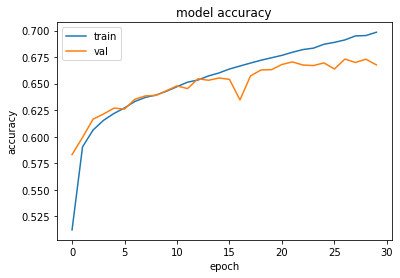

In [7]:
plt.plot(pfn.model.history.history['acc'])
plt.plot(pfn.model.history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:

# get predictions on test data
preds = pfn.predict(X_test)


100%|██████████| 60786/60786 [00:00<00:00, 89674.04it/s]


overall accuracy: 66.94 percent
ignoring 0.0 percent of 60786 events


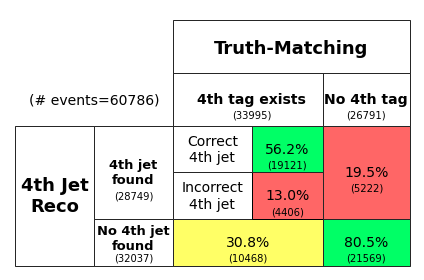

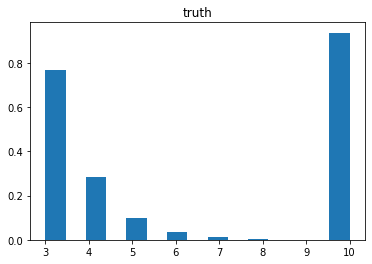

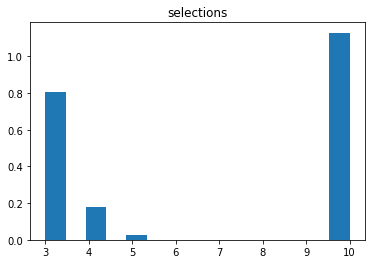

In [9]:
Y_concat = np.concatenate((np.ones((len(Y_test), 3)), Y_test), axis=1).astype(int)  # add 3 1s to the start of each event
truth = Y_concat[:,:-1]  # cut off no-jet jet
tag = X_test[:,:,3].astype(int)


preds_max = np.argmax(preds, axis=1) + 3
preds_arr = np.zeros((len(preds), len(preds[0])+3), dtype=int)
for i, p in enumerate(preds_max):
    preds_arr[i][p] = 1

# make sure we're getting the right accuracy
n_events = len(preds_arr)
n_correct = 0
for i in range(len(preds_arr)):
    if all(preds_arr[i][3:] == Y_test[i]):
        n_correct += 1
    
# chop off 'no jet' jet
selections = preds_arr[:,:-1].astype(int)


# ensure accuracy again
n_events = len(truth)
n_correct = 0
for i in range(len(truth)):
    if all(truth[i][3:] == selections[i][3:]):
        n_correct += 1

import importlib
importlib.reload(tools)

#print(truth.shape, tag.shape, selections.shape)
tools.evaluate_model(truth, tag, selections)

plt.title("truth")
plt.hist(y.argmax(axis=1), bins=15, density=True)
plt.show()


plt.title("selections")
plt.hist(preds_max, bins=15, density=True)
plt.show()
